Importing necessary libraries

In [64]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler

from keras.utils import plot_model
from tensorflow.keras.metrics import Recall
#from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall
#from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

import pickle

# The Dataset



HAM10000_metadata.csv file is the main csv file that includes the data of all training images, the features of which are -
1. Lesion_id
2. Image_id
3. Dx
4.  Dx_type
5.  Age
6.  Sex
7.  Localization



In [65]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('./archive/HAM10000_metadata.csv')

In [66]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [67]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [68]:
df.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

A statistical analysis of numerical attributes of the dataset (age)

### Data Cleaning and Management

Removing NULL values from the dataset

In [69]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are 57 NULL values in 'age' feature.
Rather than dropping the values, replacing NULL values with the mean of 'age'.

In [70]:
df['age'].fillna( df['age'].mean()  , inplace = True)

In [71]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

All NULL values are now resolved.

Now, Making a lesion type dictionary to map the lesion type to a dataframe column.

In [72]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = './archive'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [73]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ./archive\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ./archive\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ./archive\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ./archive\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ./archive\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

# Image Preprocessing

We have to resize the images from dimensions : 400 * 600 * 3 to dimensions : 125 * 100 * 3 as the model might take a lot of time to run on large dimensions of images.

In [74]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

Plotting some images from each class of dataset.

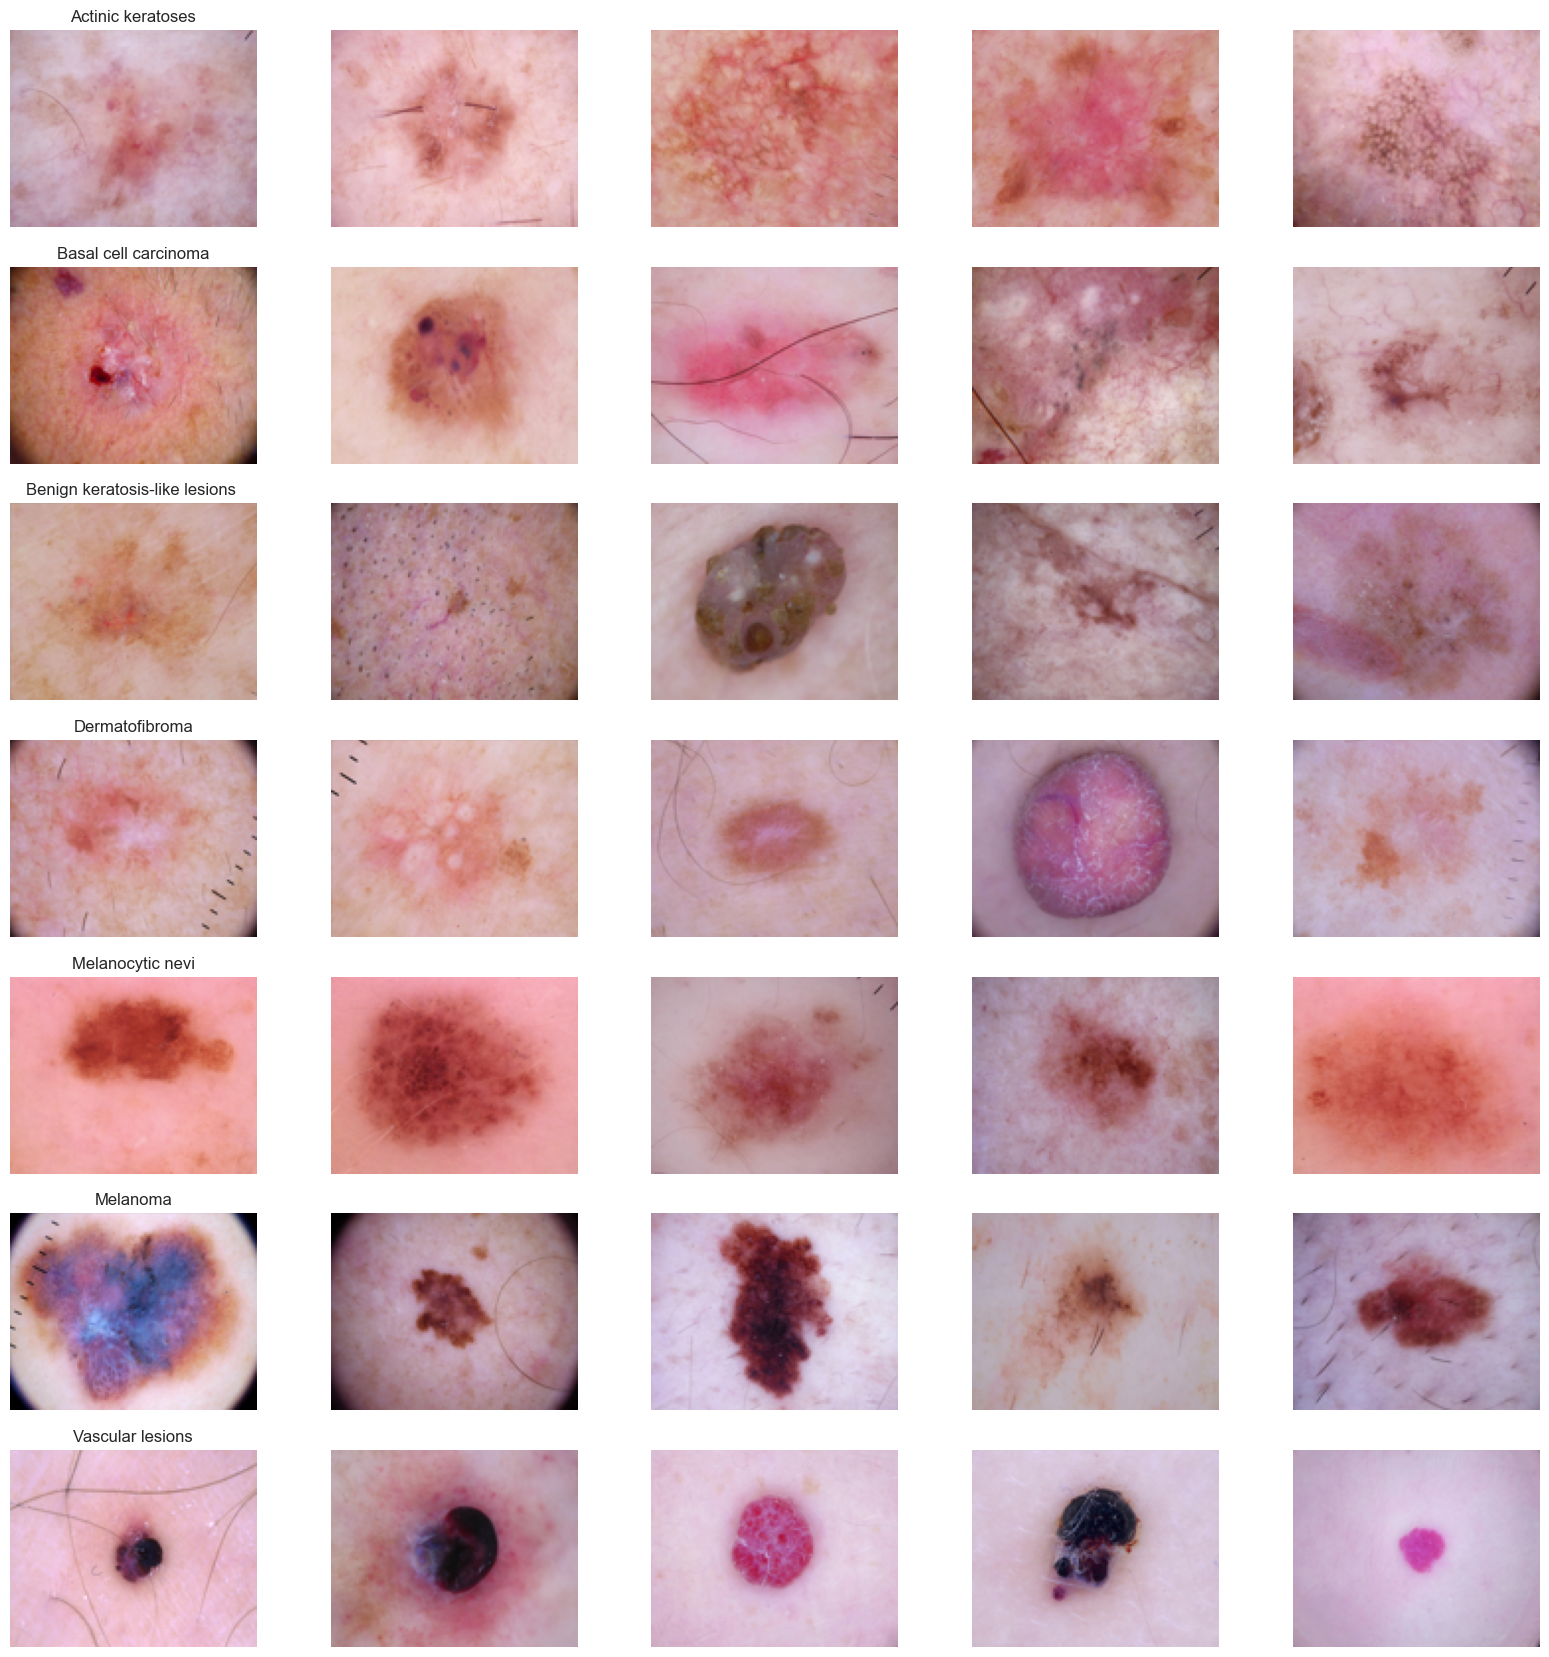

In [75]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [76]:
# to check the image size distribution - It returns one row that shows all images are uniform
df['image'].map(lambda x: x.shape).value_counts()

image
(100, 125, 3)    10015
Name: count, dtype: int64

# Implementation of ANN

A simple neural network to record patterns in images.

In [77]:
features = df.drop(columns = ['cell_type_idx'], axis = 1)
target = df['cell_type_idx']

features.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  ./archive\HAM10000_images_part_1\ISIC_0027419.jpg   
1  ./archive\HAM10000_images_part_1\ISIC_0025030.jpg   
2  ./archive\HAM10000_images_part_1\ISIC_0026769.jpg   
3  ./archive\HAM10000_images_part_1\ISIC_0025661.jpg   
4  ./archive\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  \
0  Benign keratosis-like lesions    
1  Benign keratosis-like lesions    
2  Benign keratosis-like lesions    
3  Benign keratosis-like lesions    
4  Benign keratosis-like lesions    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Implementation of CNN

The CNN model is a repeated network of the following layers:

1. Convolutional
2. Pooling
3. Dropout
4. Flatten
5.  Dense

Optimizer: Adam

Activation function used: Softmax

In [78]:
#setting up the CNN Model

input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.16))

model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(layers.Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.20))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 125, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 125, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 62, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 62, 32)        9248      
                                                        

In [79]:
# Defining the optimizer
optimizer = Adam(learning_rate = 0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

In [80]:
# Compiling the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"], run_eagerly = True)

In [81]:
# Setting a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [82]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)

# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

ValueError: Found input variables with inconsistent numbers of samples: [7511, 6759]

In [ ]:
# Fitting the model
epochs = 60
batch_size = 16
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])